## DEFINICIÓN DE CONSTANTES FUNDAMENTALES  

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
T_w = 80.0 + 273.0 # Temperatura de la pared [K]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]
delta_T = T_w - T_a
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
D = 2 * R
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
Ra_D = (g * beta * delta_T * (2 * R)**3)/ nu**2 # Numero de Rayleigh
Nu = (576/(Ra_D * 2 * R /L)**2 + 2.873/(Ra_D * 2 * R /L)**(1/2))**(-1/2)# Numero de Nusselt
h_v = (k * Nu)/ (2 * R * L) # coeficiente de tranferencia de calor por convección [W/(m^3 K)]
h = 1.42 * (delta_T/L)**(1/4)

## DEFINICIÓN DE VALORES ADIMENSIONALES

In [34]:
phi = 1/ (beta * delta_T)
Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * delta_T /  h**2 # Numero de Richardson
Ra = rho_0**2 * g * beta * Cp * D**2 * delta_T / (16 * nu * h) # Numero de Rayleigh
LAMBDA = L/D
delta = alpha * h / (L**2 * rho_0 * g * beta * Cp * delta_T)

## CALCULO DE v_0 POR NEWTON-RAPHSON

In [35]:
import math

def f(v, a, b, c, d):
    return a + b*v**2 + c*v - 1 + (v/d)*(1 - math.exp(-d/v))

def f_prime(v, b, c, d):
    return 2*b*v + c + (1/d)*(1 - math.exp(-d/v)) - (1/(d * v))*math.exp(-d/v)

def newton_raphson(a, b, c, d, v0, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, a, b, c, d) / f_prime(v, b, c, d)
        if abs(v_new - v) < tol:
            return v_new, i+1
        v = v_new
    return v, max_iter  # Retorna la última aproximación si no converge

# Ejemplo de uso
a = phi
b = Ri**-1
c = Ra**-1
d = LAMBDA
v0 = 0.1  # Valor inicial

v_sol, iterations = newton_raphson(a, b, c, d, v0)
print(f"La solución aproximada es v_e = {v_sol:.6f}")
print(f"Número de iteraciones: {iterations}")

# Verificar la solución
residual = f(v_sol, a, b, c, d)
print(f"Residual: {residual:.2e}")

v_e = v_sol


La solución aproximada es v_e = 7.241852
Número de iteraciones: 100
Residual: 4.45e+00


## LA VELOCIDAD EN EL ESTACIONARIO SERÁ

In [36]:
u_e = v_e * h_v * L / (rho_0 * Cp)
print(f'u_e = {u_e:.2f} m/s o {u_e*3.6:.2f} km/h')

u_e = 9.39 m/s o 33.81 km/h


## DISTRIBUCIÓN DE TEMPERATURAS

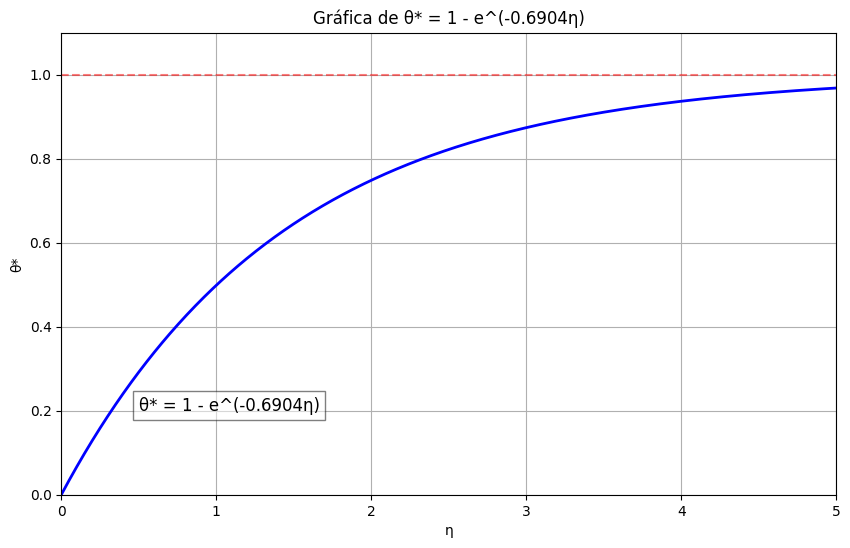

In [37]:
def theta_estrella(eta, a):
    return 1 - np.exp(-a * eta)

# Parámetros
a = h_v * L * LAMBDA / (rho_0 * Cp * u_e)  # Puedes cambiar este valor según tus necesidades

# Crear un rango de valores para eta
eta = np.linspace(0, 5, 1000)  # Ajusta el rango según sea necesario

# Calcular theta_estrella para cada valor de eta
theta = theta_estrella(eta, a)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(eta, theta, 'b-', linewidth=2)
plt.title(f'Gráfica de θ* = 1 - e^(-{a:.4f}η)')
plt.xlabel('η')
plt.ylabel('θ*')
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)  # Línea asintótica en y=1
plt.xlim(0, max(eta))
plt.ylim(0, 1.1)

# Añadir una ecuación en la gráfica
plt.text(0.5, 0.2, f'θ* = 1 - e^(-{a:.4f}η)', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()


## SIMULACIÓN NUMÉRICA

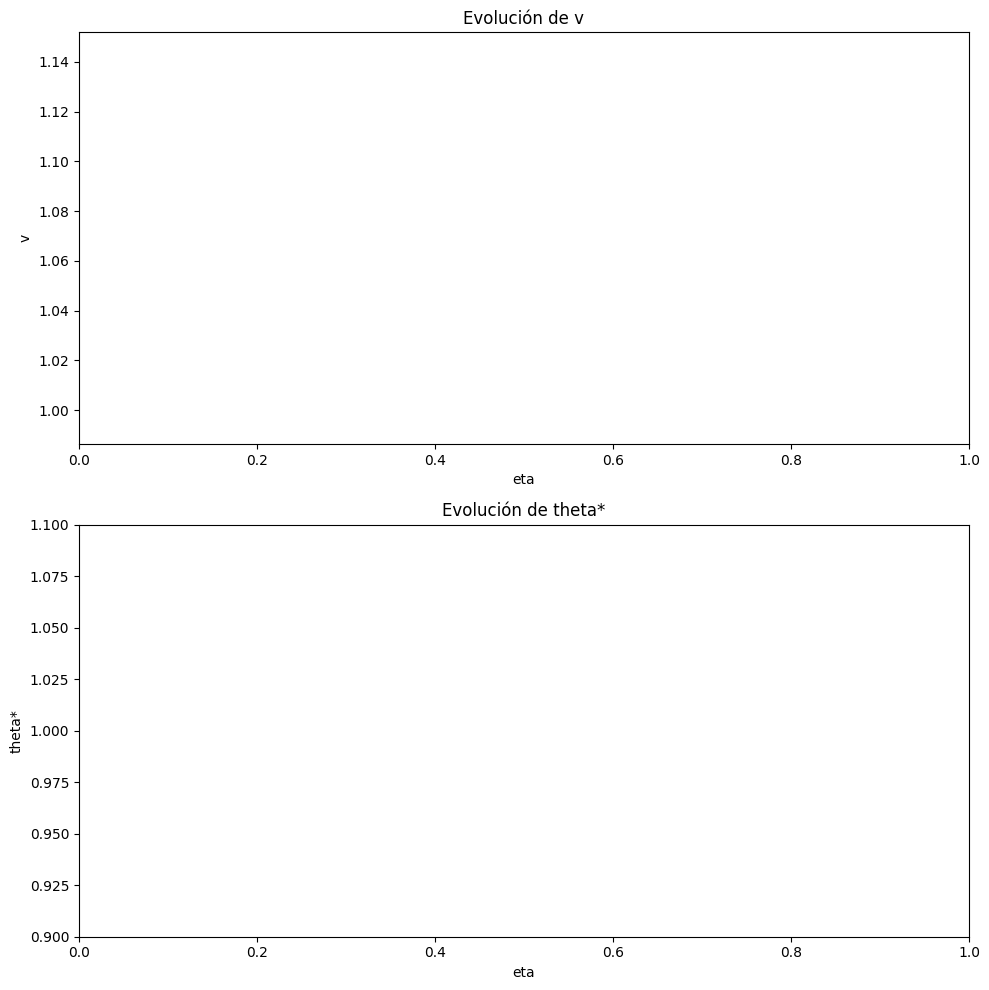

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parámetros de la simulación
Nt = 1000  # Número de pasos de tiempo
Neta = 100  # Número de puntos en la dirección eta
eta_max = 1.0
delta_tau = 0.001
delta_eta = eta_max / (Neta - 1)

# Inicialización
eta = np.linspace(0, eta_max, Neta)
v = np.ones(Neta)
theta_star = np.ones(Neta)
xi = np.zeros(Neta)

# Funciones para las derivadas
def d_deta(f):
    return np.gradient(f, delta_eta)

def d2_deta2(f):
    return np.gradient(np.gradient(f, delta_eta), delta_eta)

# Simulación
v_history = []
theta_history = []

for n in range(Nt):
    # Actualizar xi
    xi = Ri**-1 * phi**-1 * v_e**2 * v**2
    
    # Actualizar v
    dxi_deta = d_deta(xi)
    v_new = v + delta_tau * (-phi/v_e * dxi_deta - Ra**-1 * v + theta_star/v_e)
    
    # Actualizar theta_star
    dtheta_deta = d_deta(theta_star)
    d2theta_deta2 = d2_deta2(theta_star)
    theta_new = theta_star + delta_tau * (
        delta * d2theta_deta2 
        - 2 * Ri**-1 * v_e * v * dtheta_deta 
        - 2 * Ri**-1 * LAMBDA * (theta_star - 1)
    )
    
    # Actualizar valores
    v = v_new
    theta_star = theta_new
    
    # Guardar historia
    v_history.append(v.copy())
    theta_history.append(theta_star.copy())

# Convertir a arrays numpy para facilitar el manejo
v_history = np.array(v_history)
theta_history = np.array(theta_history)

# Visualización
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2)

ax1.set_xlim(0, eta_max)
v_min, v_max = v_history.min(), v_history.max()
v_range = v_max - v_min
ax1.set_ylim(v_min - 0.1*v_range, v_max + 0.1*v_range)
ax1.set_xlabel('eta')
ax1.set_ylabel('v')
ax1.set_title('Evolución de v')

ax2.set_xlim(0, eta_max)
theta_min, theta_max = theta_history.min(), theta_history.max()
theta_range = theta_max - theta_min
if theta_range == 0:
    theta_range = 1  # Establecer un rango predeterminado si es cero
ax2.set_ylim(theta_min - 0.1*theta_range, theta_max + 0.1*theta_range)
ax2.set_xlabel('eta')
ax2.set_ylabel('theta*')
ax2.set_title('Evolución de theta*')

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

def animate(i):
    line1.set_data(eta, v_history[i])
    line2.set_data(eta, theta_history[i])
    return line1, line2

anim = FuncAnimation(fig, animate, init_func=init,
                     frames=Nt, interval=20, blit=True)

plt.tight_layout()
plt.show()

